# Project 5
**Author:** Tommy Phung <br>
**Target:** Video Game Developers

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


### Modeling Libraries used 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
### Custom made functions for cleaning data
from functions import data_cleaning as dc 

## Business Understanding 
Video games have been a form of entertainment for all ages around the world. There have been an increase in game production with all the access to tools online as well as the demand for these games. Every year, steam have games published on their platform and have only been increasing in the past decade. On average, steam alone on average gets 30 games a day. With so many games getting published, there is a risk that the game wont be made profitable. 
Depending on the company size, the number of sales chanages to be seen as profitable. For example, Triple A games is expected to have a sale of 10 million units to be called profitable. Whereas Indie games, which are smaller game compnaies, would expect 100,000 units to be successful. There is also a bigger budget range when comparing Triple A compnaies and Indie companies. 
In order to make a game that many would be interested in buying, certain genres are more desirable than others for the average player. By modeling the games genre, we canisolate the genres to the best genres to have when making a game that would reach the benchmark mentioned above. 

This information would be useful to have for Indie Developer that would sell their game on Steam but can apply to other platforms. If a new developer is attempting to create a game, they should use the information to determine the best type of game that the audience would want to buy. Triple A companies using the model should look at the worst genres and avoid those since they are already estiablish and could improve their current library of games instead. 

## Data Understanding 
The dataset that I used came from a couple of sources from Kaggle 

## Import Dataset 

In [2]:
df = pd.read_csv('datasets/backloggd_games.csv', index_col= 0)
goty_df = pd.read_excel('datasets/Sample GOTY.xlsx')
ranked_df = pd.read_csv('datasets/vgsales.csv')

## Data Preperations

Before analysising the dataset, it needs to be cleaned for any missing data or any data that isn't needed for the project. <br>
Unnecessary columns are removed from the dataset that would not be used. **Wishlist, Playing and Backlog** are the number of people that want the game, is currently playing or planning on playing the selected game. This is subjective and doesn't indicate whether the game is good or bad. The column Plays, which are people that have played the game can give insight on actual players for the game. <br>

**TBD or To Be Determined** are games with not release date yet meaning that the game is too new to be analysis yet. 
Any duplicates are also removed. A thing to note is that games get rereleases so duplicates in titles are handled differently. 

The number of players in the columns **Plays and Reviews** are changed to integers for comparison. The letter **K**, stands for the thousands and changed accordingly. 

Lastly, if the games made over a million or 1 in sales, the corresding game would recieve a 1 for being true or 0 if they were not able to achieve the benchmark. 

In [3]:
df.drop(['Wishlist', 'Backlogs','Playing', 'Lists'], axis = 1, inplace= True)    ### Not needed columns
df.drop_duplicates(inplace= True)    ### Drop any duplicates

df['Plays'] = df['Plays'].apply(dc.value_to_float)   ### Convert K into 1000s
df['Reviews'] = df['Reviews'].apply(dc.value_to_float)   ### Convert K into 1000s

df.drop(df[df['Release_Date'] == 'TBD'].index, inplace= True)   ### Unfair analysis
df.Release_Date = df.Release_Date.apply(lambda x: int(x[-4:]))    ### Convert the year released to just the year. 

df.reset_index(drop= True, inplace= True)

df.Genres = df.Genres.apply(dc.convert_to_list)   ### Convert to list like
df.Developers = df.Developers.apply(dc.convert_to_list)   ### Convert to list like

In [113]:
### Add a new column with all 0. 
df['Over_1'] = 0
df['Over_.1'] = 0 
df.loc[df['Title'].isin(ranked_df[ranked_df.Global_Sales >= 1].Name.values), 'Over_1'] = 1
df.loc[df['Title'].isin(ranked_df[ranked_df.Global_Sales >= .1].Name.values), 'Over_.1'] = 1

## Data Distribution

While looking at the dataset, there is a couple of things to note in the distribution. For the number of ratings, it follows a normal distribution not including that the number of games that doesn't have a rating. 

**16.6 %** of the games were a developers **single game**. This could be misleading as some **developers changes names** or get **absorbed by companies** that would change what the game developers havppens to be. We would assume that this doesn't make a majority of games for now unless the number of games makes an impact. <br>
**15.1 %** of the games **doesn't have a game developer listed**. There is a number of reason other than missing developer name. **Newer unknown games** would have individual name rather than actual company name. This could be good to note the potential of these games since **not all good games are known or created by big companies.** 


In [115]:
df.Over_1.value_counts(normalize= True)

0    0.959802
1    0.040198
Name: Over_1, dtype: float64

In [116]:
df['Over_.1'].value_counts(normalize= True)

0    0.890369
1    0.109631
Name: Over_.1, dtype: float64

Only **4%** of the games were able to make a sale of over 1 million. <br>
While the **96%** was unable to each that benchmark. <br>
The benchmark differs from the size of the company. 
Accouring to www.engadget.com this matches up with their report of having 4% of games would make a profit. 

When cosidering the most indie games consider sales over **100,000** sales to be successful, there are more games that reached that benchmark. <br>
**90%** of games were not able to make the cut while **10%** was ablt to, doubling the number of games. This make sense since most games have to start as an indie developer before being a successful Triple A title. 

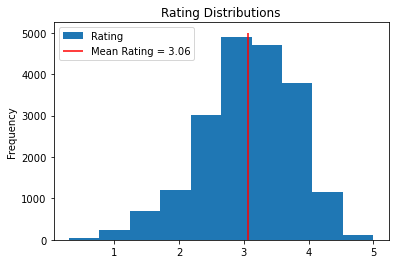

In [6]:
### Rating Distrbution 
df[df.Rating >= 0].Rating.plot(kind = 'hist', title = 'Rating Distributions', xlabel = 'Rating', sharex = False);
plt.vlines(df.Rating.mean(), 0, 5000, colors= 'red', label= 'Mean Rating = {}'.format(round(df.Rating.mean(), 2)));
plt.legend();

Normal distrbution of games would mean that all types of games were included leaving for a balanced dataset. <br>
If all or most of the **games perform well**, that would **indirectly lead** to **better sales** in most cases. 
Instead, since this website was built by the fanbase, there should be a balance of popular games and more obsure games.

In [8]:
#dev_df = pd.concat([df.Title, pd.get_dummies(df['Developers'].explode(),drop_first= True).groupby(level=0).sum(), df[['Over_1']]], axis= 1)
genre_df = pd.concat([df.Title, pd.get_dummies(df['Genres'].explode(),drop_first= True).groupby(level=0).sum(), df[['Over_1']]], axis= 1)

## Baseline Model
A basic Decision Tree was made for the baseline model to compare the other model in mind. 
The features used were the different genres that each game labeled as and the targeted feature was the whether the game was able to reach 1 million in sales, Over_1 column.

In [9]:
X = genre_df[genre_df.columns[1:-1]]
y =  genre_df.Over_1
X_train, X_test, y_train, y_test = train_test_split(X, y,)
                                                            
baseline = DecisionTreeClassifier(random_state=10)  

baseline.fit(X_train, y_train) 
baseline.score(X_test, y_test)

DecisionTreeClassifier(random_state=10)

### Feature Importance and Genre Distribution
The model provides a feature importance for each feature giving a percentage to deteermine which was the most important when deciding the relavence of the genres. 
However, it is important to see the distribution of the genres alone to see if the data would favor one genre of another. Assuming that the more games with a given genre would be picked out more often than a rare genre. 

In [117]:
feature_list = []
for name, value in zip(classifier.feature_names_in_, classifier.feature_importances_):
    feature_list.append((name, round(value*100, 2)))
feature_list = sorted(feature_list, key= lambda x: x[1])

all_genres = df.Genres.values
split_genres = {}
for group in all_genres:
    #new_list = group.strip('\'[ ]').split('\', \'')
    
    for element in group:
        if element == '':
            break
        key = element
        if split_genres.get(key) == None:
            split_genres[key] = 1 
        else:
            split_genres[key] += 1
sort_genres = dict(sorted(split_genres.items(), key = lambda x: x[1], reverse= False))

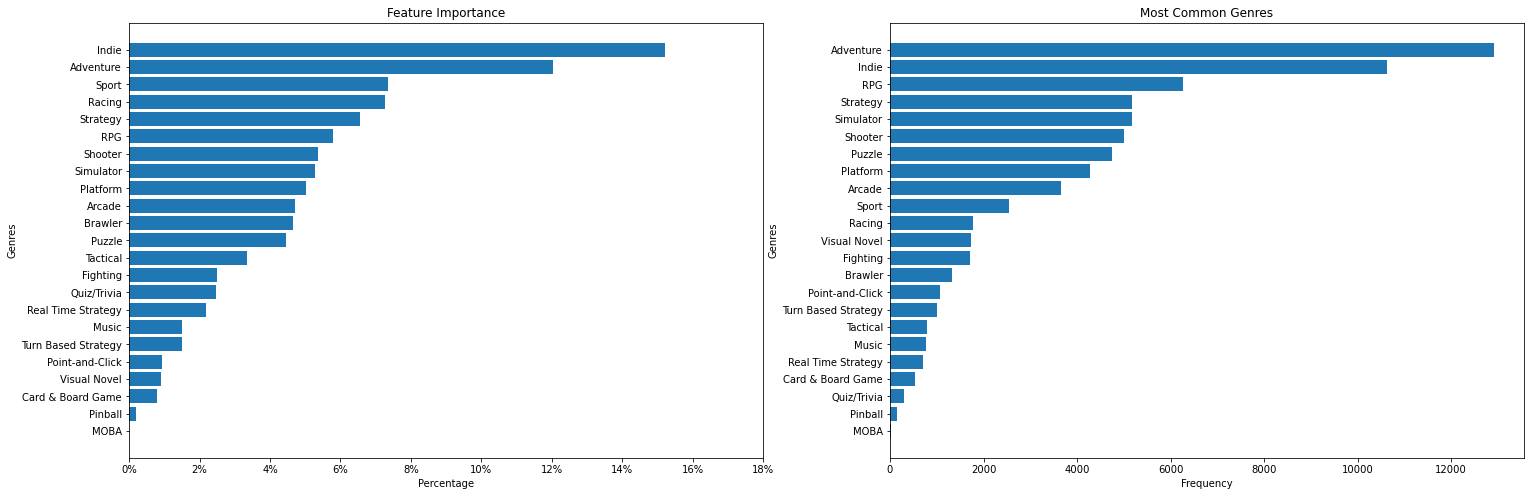

In [118]:
fig, ax = plt.subplots(ncols= 2,figsize = (25,8))
x_feat = [x[0] for x in feature_list]
y_feat = [x[1] for x in feature_list]
ax[0].barh(x_feat, y_feat)
ax[0].set_title('Feature Importance')
xlabel = ['{}%'.format(x) for x in np.arange(0,20,2)]
ax[0].set_xticks(np.arange(0,20,2));
ax[0].set_xticklabels(xlabel);
ax[0].set_ylabel('Genres');
ax[0].set_xlabel('Percentage');

ax[1].barh(list(sort_genres.keys()), list(sort_genres.values()));
ax[1].set_title('Most Common Genres');
ax[1].set_ylabel('Genres');
ax[1].set_xlabel('Frequency');

Its good to know that not all the genres corralate to the most common genre, meaning that some genres are more influncetial to have than others. This also means that some genre can be interpretted as saturated since even though they make up most of the games genres, they dont perform well in sells. 
Indie games are both a common genre and important based off the model. Uncommone genres like Pinball, Cards, and Trivia doesn't perform well and not in the market for good reason. 

In [137]:
test_df = pd.concat([X_test.reset_index(), pd.Series(classifier.predict(X_test), name = 'Pred')], axis= 1)

In [138]:
test_df.loc[test_df['Pred'] == 1]

,index,Adventure,Arcade,Brawler,Card & Board Game,Fighting,Indie,MOBA,Music,Pinball,...,Racing,Real Time Strategy,Shooter,Simulator,Sport,Strategy,Tactical,Turn Based Strategy,Visual Novel,Pred
11,24861,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
636,3135,0,0,0,0,0,0,0,0,0,...,0,1,1,0,0,1,0,0,0,1
1935,2039,0,1,0,0,1,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
2989,11608,0,0,0,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
3266,986,0,0,0,0,0,0,0,1,0,...,1,0,0,0,1,0,0,0,0,1
4089,35355,1,0,1,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,1
4267,29541,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4503,13909,0,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4675,15756,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1
4913,1441,1,0,1,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,0,1


In [ ]:
df.iloc[test_df.loc[test_df['Pred'] == 1]['index'].values]

In [142]:
test_df['True_Pred'] = y_test.values

In [143]:
test_df

,index,Adventure,Arcade,Brawler,Card & Board Game,Fighting,Indie,MOBA,Music,Pinball,...,Real Time Strategy,Shooter,Simulator,Sport,Strategy,Tactical,Turn Based Strategy,Visual Novel,Pred,True_Pred
0,24085,1,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
1,29736,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,10735,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,31249,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,10790,0,1,0,0,1,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9231,11107,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9232,28150,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9233,14622,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9234,9316,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
